In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import time
from numba import njit,prange

In [49]:
@njit(boundscheck=True)
def Strap(Vrf, Vdc):
    
    #Define the parameters that make up your trap
    eps = 0.97413; #roughly the eccentricity
    f = 1; #flattening
    a = 0.05; #semi-minor axis
    c = 0.226*a; #distance from center to pole, semi major #0.293 is the exact like his photo, but doesn't give as good of a trap
    Rmin = 0.0113; #radius of the waist of the ellipsoid
    m = 0.005; #additional mirror thickness horizontal
    t =  0.03; # the very top of the mirror
    s = -0.0505;#-0.025; # the bottom of the grounded part/the top of the RF part
    u = -0.046965; # where the top of the laser opening is
    d = -0.048465; # where the bottom of the laser opening is
    b = -0.0525; # The bottom of the mirror block
    Hneedle = -0.0009; #height of needle inside trap up until the beginning of the needle tip
    Rneedle = 0.00023; #radius of needle
    HneedleTip = 0.0024; # height of needle tip from needle body
    RneedleTip = 0.0001; # The ball on top of the needle
    Bneedle = b; #where the needle begins
    Rhole = 0.0013; #radius of the hole
    Hoffset = -0.0472; #offset of the hole in the x direction
    COuterR = 0.0005; # The outer radius of the central grounded electrode
    CInnerR = 0.0002; # The inner radius of the central grounded electrode
    CHeight = 0.0009; # The half height of the central grounded electrode
    RFOuterR = 0.001; # The outer radius of the RF electrode
    RFInnerR = 0.0007; # The inner radius of the RF electrode
    RFHeight = 0.00085; # The half height of the RF electrode

     
    
    #Properties of our grid
    gmax = 0.055 #physical size of the space simulated (meters)
    points = 401 # number of points that are being simulated
    steps = points - 1 # just the number of points minus one
    x = np.linspace(-gmax, gmax, points) #chosing how much space in the x, y, z direction, where it begins and where it ends
    y = np.linspace(-gmax, gmax, points)
    z = np.linspace(-gmax, gmax, points)
    size = len(x) # telling it how to organize these spaces
    sizeZ = len(z)
    xmid = int((size)/2)
    ymid = int((size)/2)
    zmid = int((sizeZ)/2) 
    lattice_points=np.zeros((size**3,3))
    marker=0 #What do these mean?
    
    V0 = np.zeros((size, size, size)) #initialize the matrix for electric potential
    V0dc= np.zeros((size, size, size))
    V0_temp=np.zeros((size, size, size))
    V0dc_temp=np.zeros((size, size, size))
    cords=np.zeros((size, size, size, 3))
    iterations = 400 #number of iterations
    CenterV = np.zeros((iterations,1)) #keep track of the potential value at the center at each iteration
    
    # Now define the boundry conditions
    for i in range(len(x)):
        for j in range(len(y)):
            for k in range(len(z)):
                cords[i, j, k] = [i, j, k]
                
                 #The ellipsoidal mirror part 1, the a of the astc(all students take calculus)
                if ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > s) and (x[i] > 0) and (y[j] > 0)):# and (x[i] > 0) and (x[i] < Rmin + m) and (y[j] > 0) and (y[j] < Rmin + m)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > s) and (x[i] > 0) and (y[j] > 0)):# and (x[i] > 0) and (x[i] < Rmin + m) and (y[j] > 0) and (y[j] < Rmin + m)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < t) and (z[k] > s) and (x[i] > 0) and (y[j] > 0)): #other part of mirror going around the top of ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > s) and (x[i] > 0) and (y[j] > 0)):#other part of mirror going around the bottom of ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t ) and (z[k] > s) and (x[i] > 0) and (y[j] > 0)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > s) and (x[i] > 0) and (y[j] > 0)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                    
                #The ellipsoidal mirror part 2, the s of the astc(all students take calculus)
                elif ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > s) and (x[i] > 0) and (y[j] < 0)):# and (x[i] > 0) and (x[i] < Rmin + m) and (y[j] > 0) and (y[j] < Rmin + m)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > s) and (x[i] > 0) and (y[j] < 0)):# and (x[i] > 0) and (x[i] < Rmin + m) and (y[j] > 0) and (y[j] < Rmin + m)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < t) and (z[k] > s) and (x[i] > 0) and (y[j] < 0)): #other part of mirror going around the top of ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > s) and (x[i] > 0) and (y[j] < 0)):#other part of mirror going around the bottom of ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t ) and (z[k] > s) and (x[i] > 0) and (y[j] < 0)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > s) and (x[i] > 0) and (y[j] < 0)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                    
                #The ellipsoidal mirror part 3, the t of the astc(all students take calculus)
                elif ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > s) and (x[i] < 0) and (y[j] < 0)):# and (x[i] > 0) and (x[i] < Rmin + m) and (y[j] > 0) and (y[j] < Rmin + m)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > s) and (x[i] < 0) and (y[j] < 0)):# and (x[i] > 0) and (x[i] < Rmin + m) and (y[j] > 0) and (y[j] < Rmin + m)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < t) and (z[k] > s) and (x[i] < 0) and (y[j] < 0)): #other part of mirror going around the top of ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > s) and (x[i] < 0) and (y[j] < 0)):#other part of mirror going around the bottom of ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t ) and (z[k] > s) and (x[i] < 0) and (y[j] < 0)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > s) and (x[i] < 0) and (y[j] < 0)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                    
                #The ellipsoidal mirror part 4, the c of the astc(all students take calculus)
                elif ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > s) and (x[i] < 0) and (y[j] > 0)):# and (x[i] > 0) and (x[i] < Rmin + m) and (y[j] > 0) and (y[j] < Rmin + m)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > s) and (x[i] < 0) and (y[j] > 0)):# and (x[i] > 0) and (x[i] < Rmin + m) and (y[j] > 0) and (y[j] < Rmin + m)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < t) and (z[k] > s) and (x[i] < 0) and (y[j] > 0)): #other part of mirror going around the top of ellipsoid
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > s) and (x[i] < 0) and (y[j] > 0)):#other part of mirror going around the bottom of ellipsoid
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t ) and (z[k] > s) and (x[i] < 0) and (y[j] > 0)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > s) and (x[i] < 0) and (y[j] > 0)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                
                #The bottom portion of the mirror that will be a DC electrode
                elif ((x[i] < Rmin + m) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin -m) and (z[k] > b) and (z[k] < s)):
                    V0[i, j, k] = Vrf[4]
                    V0dc[i, j, k] = Vdc[4]
                
                else:
                    V0[i, j, k] = 0
                    V0dc[i, j, k] = 0
                    lattice_points[marker]=[i,j,k]
                    marker+=1
                    
                    
    lattice_points=lattice_points[0:marker] # what does this mean?    
    
    V0_temp=V0    
    V0dc_temp=V0dc
    
    return V0,V0dc,CenterV,lattice_points,cords

In [50]:
#Voltages used in the simulation
RF=np.array([0, 1, 1, 1, 1]) #corresponding to each portion of the mirror geometry
DC=np.array([1, 2, 3, 4, 5])

start=time.time() # Records the time started.

A=Strap(RF,DC) # Runs the simulation

print("The time elapsed is ",time.time()-start, "seconds")

The time elapsed is  93.85966610908508 seconds


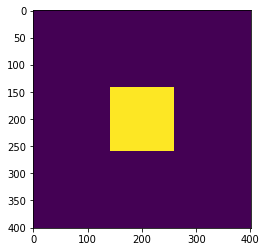

In [56]:
###################PLOTTING EXAMPLES###########
# plot the xy plane for the dc potential
plt.imshow(A[1][:,:,16], cmap=plt.cm.get_cmap('viridis', 20))
#plt.axis([1, 110, 150, 250])